# Simulating mutations with msprime

First, should talk about why you might not always need to do this.

In msprime simulations, the genealogy is independent of the genetic variation (Actually I don't think this is quite the right way to phrase it, because the mutation table is conditional on a specific tree... think more). You simulate the underlying genealogy first, as a set of node and edge tables, and *then* if desired, you simulate mutations to go with that genealogical structure. However, in many situations, the genealogy is all you need. 

Think carefully. Does your application *need* information about alleles and mutations? If not, save yourself (and your computer) some effort. The genealogy will in itself give you information about times, MRCAs, segments of identity-by-descent amongst other things. In later worksheetw we will see more examples of analyses that do not rely on mutations.

But in this worksheet, we're going to focus on how to do mutation simulations, should you need to look at actual genome **sequences**....

## A basic tree sequence to work with + packages

To emphasise that mutations and genealogy are truly separate in msprime, we will use the same simulated genealogy (ie. node and edge table) in all of the simulations in this worksheet. Everything else we do will just be throwing different sets of mutations on top of these trees, to produce different genomic sequences.

In [17]:
import msprime, tskit
import numpy as np
from IPython.display import SVG
msprime.__version__

'1.0.1'

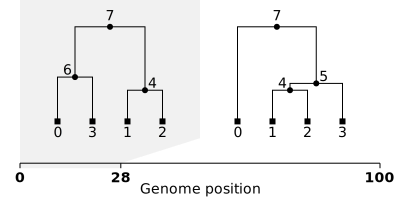

In [90]:
ts = msprime.sim_ancestry(2, sequence_length=100, random_seed=1987, recombination_rate=0.001)
SVG(ts.draw_svg())

## Syntax

The basic syntax is to apply the `sim_mutations()` method to an existing tree sequence with nodes and edges.
At minimum, you must supply a per-base, per-generation mutation rate.
By default, the mutation are simulated under a discrete Jukes-Cantor model (we'll discuss further below).
The output is another tree sequence, but this time with mutations on particular edges of the trees:

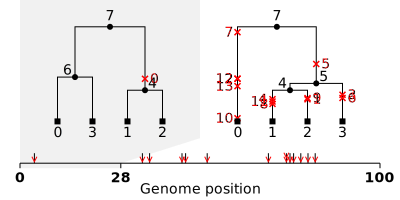

In [5]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=2016)
# print(mts.num_sites)
# print(mts.num_mutations)
SVG(mts.draw_svg())

Under the hood, you'll notice that there are two more tables in the tree sequence.
One holds information about mutations:

In [6]:
mts.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,4,1.23594006,G,-1,b''
1,1,2,0.64084744,A,-1,b''
2,2,0,1.24046744,G,-1,b''
3,3,3,0.77282302,T,-1,b''
4,4,1,0.64477329,G,-1,b''
5,5,5,1.66530382,G,-1,b''
6,6,3,0.68047396,T,-1,b''
7,7,0,2.58755779,A,-1,b''
8,7,1,0.50759097,C,-1,b''
9,8,2,0.67574069,G,-1,b''


The other holds information about the sites at which these mutations arose:

In [7]:
mts.tables.sites

id,position,ancestral_state,metadata
0,4.00000000,C,b''
1,34.00000000,C,b''
2,36.00000000,T,b''
3,45.00000000,C,b''
4,46.00000000,A,b''
5,52.00000000,T,b''
6,69.00000000,G,b''
7,74.00000000,G,b''
8,75.00000000,A,b''
9,76.00000000,A,b''


(Why are there two different tables? Basically, because of back mutations. You may have a single site at which multiple mutations occured.) Other tables the same as in the original tree sequence.

In [8]:
# for var in mts.variants():
#     print(var.site.position, var.alleles, var.genotypes, sep="\t")

## Mutation models and 'stackability' of mutations

By default, `msprime` invokes a Jukes-Cantor model of nucleotide mutations.
Under this model, there is an equal probability of each ancestral state (`A`, `C`, `G`, `T`), and an equal probability of each possible transition between these states (`A<->C`, `A<->G` etc).

This property is in the `transition_matrix` of the mode:

In [21]:
msprime.JC69().transition_matrix

array([[0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.        , 0.33333333],
       [0.33333333, 0.33333333, 0.33333333, 0.        ]])

In our case, we can eyeball all the mutations that has arisen in our simulations

In [9]:
for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

4.0	('C', 'G')	[0 1 1 0]
34.0	('C', 'A')	[0 0 1 0]
36.0	('T', 'G')	[1 0 0 0]
45.0	('C', 'T')	[0 0 0 1]
46.0	('A', 'G')	[0 1 0 0]
52.0	('T', 'G')	[0 1 1 1]
69.0	('G', 'T')	[0 0 0 1]
74.0	('G', 'A', 'C')	[1 2 0 0]
75.0	('A', 'G')	[0 0 1 0]
76.0	('A', 'G')	[1 0 0 0]
78.0	('C', 'A')	[0 1 0 0]
80.0	('G', 'T')	[1 0 0 0]
82.0	('T', 'C')	[1 0 0 0]


And summarise it like this, with some extra code

In [22]:
def count_transitions(ts, alleles):
    counts = np.zeros((len(alleles), len(alleles)), dtype='int')
    for s in ts.sites():
        aa = s.ancestral_state
        for m in s.mutations:
            pa = aa
            da = m.derived_state
            if m.parent != tskit.NULL:
                pa = ts.mutation(m.parent).derived_state
            counts[alleles.index(pa), alleles.index(da)] += 1
    print("\t", "\t".join(alleles))
    for j, a in enumerate(alleles):
        print(f"{a}\t", "\t".join(map(str, counts[j])))
        
count_transitions(mts, msprime.JC69().alleles)

	 A	C	G	T
A	 0	0	3	0
C	 2	0	1	1
G	 1	1	0	2
T	 0	1	2	0


What are the other options?

### HKY

In some situations you'll want nucleotide transitions (`A<->G`), (`C<->T`) (ie. exchanges of bases with a similar shape) to be more likely than nucleotide tranversions (all others).
You can do this with the Hasegawa, Kishino & Yano (HKY) model.
In addition to a mutation `rate`, which specifies the probability of transversions, you also specify `kappa`, a constant scaling parameter such that the probability of transitions is `kappa` times the probability of transversions.

In [23]:
msprime.HKY(kappa=20).transition_matrix

array([[1.11022302e-16, 4.54545455e-02, 9.09090909e-01, 4.54545455e-02],
       [4.54545455e-02, 0.00000000e+00, 4.54545455e-02, 9.09090909e-01],
       [9.09090909e-01, 4.54545455e-02, 1.11022302e-16, 4.54545455e-02],
       [4.54545455e-02, 9.09090909e-01, 4.54545455e-02, 1.11022302e-16]])

You'll notice that there is now a very small (non-0) probability of *silent mutations* -- transitions from one state to the other. We'll discuss why soon.

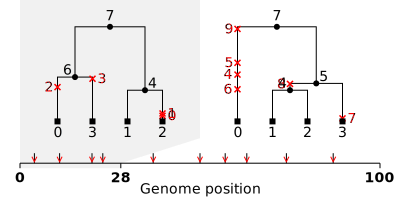

In [24]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=2022, model=msprime.HKY(kappa=20))
SVG(mts.draw_svg())

Now, most of the mutations are transitions. (Also, note that the site with multiple mutations now experiences a back mutation).

In [25]:
for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

4.0	('G', 'T')	[0 0 1 0]
11.0	('C', 'T')	[0 0 1 0]
20.0	('C', 'A')	[1 0 0 0]
23.0	('T', 'C')	[0 0 0 1]
37.0	('A', 'G')	[1 0 0 0]
50.0	('G', 'A')	[1 0 0 0]
57.0	('T', 'C')	[1 0 0 0]
63.0	('C', 'T')	[0 0 0 1]
74.0	('A', 'G')	[0 1 1 0]
87.0	('C', 'T')	[1 0 0 0]


In [28]:
count_transitions(mts, msprime.HKY(kappa=20).alleles)

	 A	C	G	T
A	 0	0	2	0
C	 1	0	0	3
G	 1	0	0	1
T	 0	2	0	0


### GTR

(Maybe omit this...)
For even more control, what if you want to specify each nucleotide substitution individually?
Then you want the GTR (Generalised Time-Reversible) model.
Would recommend looking up the documentation (put in a link) if you want to use this one, but essentially, in addition to specifying an equilibrium mutation `rate`, you also specify some `relative_rates`, which indicate the relative frequency of each of the possible nucleotide switches: (`A<->C`, `A<->G`, `A<->T`, `C<->G`, `C<->T`, `G<->T`).

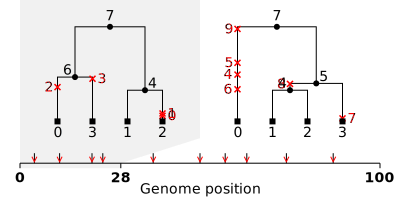

In [29]:
mts = msprime.sim_mutations(
    ts, rate=0.01, random_seed=2022, model=msprime.GTR(relative_rates=[1,2,1,2,1,2]))
SVG(mts.draw_svg())

### Models where the mutations aren't nucleotides

So far, we've been thinking about genomic locations in terms of nucleotides, and mutations as nucloeotide substitutions.
However, msprime just seems these genomic locations as numbers along a line, and there's no reason why those numbers can't represent other more general entities

(need to ask/figure out what this actually does to the mutation rate and its interpretation)

In [31]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=2021,
                            model=msprime.PAM())

Now, all of the variants are one of the first 20 letters in the latin alphabet, representing an amino acid of some sort. 

In [32]:
for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

0.0	('K',)	[0 0 0 0]
40.0	('I',)	[0 0 0 0]
44.0	('G',)	[0 0 0 0]
45.0	('W',)	[0 0 0 0]
60.0	('C',)	[0 0 0 0]
68.0	('E', 'G')	[0 1 0 0]
74.0	('L',)	[0 0 0 0]
76.0	('L', 'I')	[1 0 0 0]
84.0	('M',)	[0 0 0 0]
86.0	('K',)	[0 0 0 0]


## Silent mutations and adjustments

Note that most of these are *silent mutations*? This the main 'gotcha' to keep in mind if you are simulating with a finite-sites (parent-independent) model.

(Also -- why aren't these all the same? And why aren't they symmetric? does the PAM model the chance of each nucleotide changing?)

(this is a section that requires some 'lecture content'

In [45]:
msprime.PAM().transition_matrix[:4,:4]

array([[2.53731698e-01, 6.14375962e-03, 2.23224538e-02, 3.15381787e-02],
       [1.30864303e-02, 5.14926581e-01, 7.41589866e-03, 0.00000000e+00],
       [4.81027017e-02, 7.50247128e-03, 1.11022302e-16, 2.34774581e-01],
       [5.86240591e-02, 0.00000000e+00, 2.02517620e-01, 2.08958712e-01]])

In [46]:
np.sum(msprime.PAM().transition_matrix[1,:])

1.0

Note that the probability of an `A<->A` transition is *more* likely than an `A->B`, `A->C`, `A->D` transition etc!
This produces silent mutations.
The reason why this happens: it's a workaround to ensure that `msprime` does not simulate nonsensical mutations.

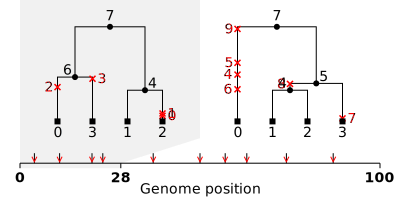

In [33]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=2022,
                            model=msprime.PAM())
SVG(mts.draw_svg())

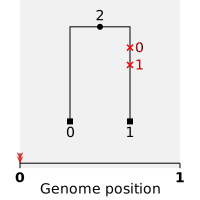

In [78]:
ts_1locus = msprime.sim_ancestry(1, sequence_length=1, random_seed=1991)
mts_1locus = msprime.sim_mutations(ts_1locus, rate=0.5, random_seed=42,
                            model=msprime.JC69())
SVG(mts_1locus.draw_svg())

In [79]:
for var in mts_1locus.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

0.0	('A', 'G')	[0 0]


In [80]:
mts_1locus.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,1,1.14736585,G,-1,b''
1,0,1,0.87830371,A,0,b''


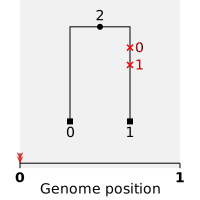

In [85]:
ts_1locus = msprime.sim_ancestry(1, sequence_length=1, random_seed=1991)
mts_1locus = msprime.sim_mutations(ts_1locus, rate=0.5, random_seed=42,
                            model=msprime.JC69(state_independent=False))
SVG(mts_1locus.draw_svg())

In [87]:
mts_1locus.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,1,1.14736585,G,-1,b''
1,0,1,0.87830371,A,0,b''


'mutation flags', are they a thing?

mention the SLiM mutation model, for anyone using SLiM

### Make-your-own mutation model!

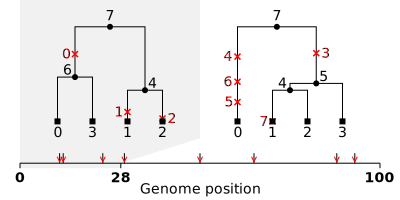

In [91]:
alleles = ["💩", "🎄", "🔥"]
model = msprime.MatrixMutationModel(
    alleles,
    root_distribution = [1.0, 0.0, 0.0],
    transition_matrix = [[0.0, 1.0, 0.0],
                         [0.0, 0.8, 0.2],
                         [1.0, 0.0, 0.0]]
)
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=1, model=model)
SVG(mts.draw_svg())

## Variation in mutation rates across the genome

You can specify mutation hotspots using the `RateMap` method as an argument to `rate`, instead of the single number:

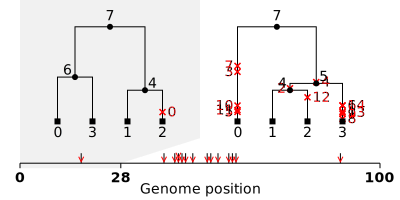

In [100]:
ratemap = msprime.RateMap(position=[0, 40, 60, 100], rate=[0.01, 0.1, 0.01])
mts = msprime.sim_mutations(ts, rate=ratemap, random_seed=104)
SVG(mts.draw_svg())

### Exercise:
Modify the following code to simulate mutations on top of the `ts` tree sequence, using a blah blah model where transpositions are 5 times more likely than transversions, with a hotspot between locations 25 and 50.

## Exporting into other formats

To run analyses using the sequence data you've just simulated, you have a lot of different approaches to consider.
One thing that I'll mention briefly now, demonstrate fully later, is that there is a lot you can do using the tree sequence objects on their own. If there is a way to do the operation using `tskit`, we recommend it, as on realistically sized datasets, it will almost always be quicker and more memory-efficient.
However sometimes you can't avoid exporting the data into another format, like VCF, in order to work with other software

### Within tskit - genotype matrices, variant call files

### To other science libraries like sci-kit-allel

### To VCF
Basic syntax:

In [117]:
mts.num_individuals

2

In [118]:
with open("worksheet3-output.vcf", "w") as vcf_file:
    mts.write_vcf(vcf_file)

What the output looks like

In [120]:
with open("worksheet3-output.vcf", "r") as f:
    print(f.read())

##fileformat=VCFv4.2
##source=tskit 0.4.1
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=100>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	individual_1	individual_2
1	17	.	C	A	.	PASS	.	GT	0|0	1|0
1	40	.	A	C	.	PASS	.	GT	0|0	0|1
1	43	.	T	C	.	PASS	.	GT	0|1	1|0
1	44	.	G	C,T	.	PASS	.	GT	1|2	2|2
1	45	.	T	A	.	PASS	.	GT	1|0	0|0
1	46	.	C	A	.	PASS	.	GT	0|0	0|1
1	48	.	G	C	.	PASS	.	GT	1|0	0|0
1	52	.	G	A	.	PASS	.	GT	0|0	0|1
1	53	.	C	T	.	PASS	.	GT	0|0	0|1
1	55	.	A	G	.	PASS	.	GT	1|0	0|0
1	58	.	G	T	.	PASS	.	GT	1|0	0|0
1	59	.	T	C	.	PASS	.	GT	0|0	1|0
1	60	.	C	G	.	PASS	.	GT	0|0	0|1
1	89	.	A	C	.	PASS	.	GT	0|0	0|1



Fancier version, if you want to specify your own individual names:

In [123]:
indv_names = ["platypus_1", "platypus_2"]
with open("worksheet3-output.vcf", "w") as vcf_file:
    mts.write_vcf(vcf_file, individual_names=indv_names)

In [124]:
with open("worksheet3-output.vcf", "r") as f:
    print(f.read())

##fileformat=VCFv4.2
##source=tskit 0.4.1
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=100>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	platypus_1	platypus_2
1	17	.	C	A	.	PASS	.	GT	0|0	1|0
1	40	.	A	C	.	PASS	.	GT	0|0	0|1
1	43	.	T	C	.	PASS	.	GT	0|1	1|0
1	44	.	G	C,T	.	PASS	.	GT	1|2	2|2
1	45	.	T	A	.	PASS	.	GT	1|0	0|0
1	46	.	C	A	.	PASS	.	GT	0|0	0|1
1	48	.	G	C	.	PASS	.	GT	1|0	0|0
1	52	.	G	A	.	PASS	.	GT	0|0	0|1
1	53	.	C	T	.	PASS	.	GT	0|0	0|1
1	55	.	A	G	.	PASS	.	GT	1|0	0|0
1	58	.	G	T	.	PASS	.	GT	1|0	0|0
1	59	.	T	C	.	PASS	.	GT	0|0	1|0
1	60	.	C	G	.	PASS	.	GT	0|0	0|1
1	89	.	A	C	.	PASS	.	GT	0|0	0|1



### To other Python objects

Many of the underlying attributes of tskit objects are `numpy` objects, so play well with other Python libraries, including plotting libraries like `matplotlib` and scientific libraries like `scikit-allel`.

In particular, the `genotype_matrix` method will return an object that works as a HaplotypeArray in scikit-allel, which gives you access to summary functions.

In [129]:
import allel

(Confusingly named `genotype matrix`, but is actually haplotypes)

In [128]:
gens = mts.genotype_matrix()
print(gens)

[[0 0 1 0]
 [0 0 0 1]
 [0 1 1 0]
 [1 2 2 2]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]]


Can easily be converted into the right objects for analyses with `allel`.

In [132]:
haps = allel.HaplotypeArray(gens)
allele_counts = haps.count_alleles()

In [133]:
allel.mean_pairwise_difference(allele_counts)

array([0.5       , 0.5       , 0.66666667, 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       ])

In [140]:
g = allel.read_vcf("worksheet3-output.vcf")
allel_g = g['calldata/GT']

In [143]:
allel.heterozygosity_observed(allel_g)

array([0.5, 0.5, 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5])

In [145]:
allel.sfs_folded(allele_counts)

ValueError: only biallelic variants are supported

But, this takes a long time on big datasets. Some of these operations can be done much more quickly within tskit itself, which we'll get to next time.

## Basic statistics minor alleles, # of segregating sites..., numpy analyses